import cv2
import numpy as np
import imutils

In [1]:
import cv2
import numpy as np
from imutils import contours
import imutils

In [2]:
image = cv2.imread("final1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

In [3]:
#ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

In [4]:
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))

In [5]:
#dilate = cv2.dilate(thresh1, None, iterations=1)
dilate = cv2.dilate(thresh1, rect_kern, iterations = 2)

In [6]:
def extract_digits_and_symbols(dilate, charCnts, minW=5, minH=15):
    # grab the internal Python iterator for the list of character
    # contours, then  initialize the character ROI and location
    # lists, respectively
    charIter = charCnts.__iter__()
    rois = []
    locs = []
    # keep looping over the character contours until we reach the end
    # of the list
    while True:
        try:
            # grab the next character contour from the list, compute
            # its bounding box, and initialize the ROI
            c = next(charIter)
            (cX, cY, cW, cH) = cv2.boundingRect(c)
            roi = None
            # check to see if the width and height are sufficiently
            # large, indicating that we have found a digit
            if cW >= minW and cH >= minH:
				# extract the ROI
                roi = image[cY:cY + cH, cX:cX + cW]
                rois.append(roi)
                locs.append((cX, cY, cX + cW, cY + cH))
                # otherwise, we are examining one of the special symbols
            else:
				# MICR symbols include three separate parts, so we
				# need to grab the next two parts from our iterator,
				# followed by initializing the bounding box
				# coordinates for the symbol
                parts = [c, next(charIter), next(charIter)]
                (sXA, sYA, sXB, sYB) = (np.inf, np.inf, -np.inf,-np.inf)
                # loop over the parts
                for p in parts:
					# compute the bounding box for the part, then
					# update our bookkeeping variables
                    (pX, pY, pW, pH) = cv2.boundingRect(p)
                    sXA = min(sXA, pX)
                    sYA = min(sYA, pY)
                    sXB = max(sXB, pX + pW)
                    sYB = max(sYB, pY + pH)
                # extract the ROI
                roi = image[sYA:sYB, sXA:sXB]
                rois.append(roi)
                locs.append((sXA, sYA, sXB, sYB))
                # we have reached the end of the iterator; gracefully break
        # from the loop
        except StopIteration:
            break
    # return a tuple of the ROIs and locations
    return (rois, locs)

In [7]:
refCnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[1] if imutils.is_cv3() else refCnts[0]
#refCnts = imutils.grab_contours(refCnts)
sorted_ctrs = sorted(refCnts, key=lambda ctr: cv2.boundingRect(ctr)[1] + cv2.boundingRect(ctr)[0] * image.shape[0] )
#refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
# create a clone of the original image so we can draw on it
orig = np.dstack([image.copy()])
#orig = image.copy()
i=0
#clone = np.dstack([dilate.copy()] * 3)
# loop over the (sorted) contours
for cnt in sorted_ctrs:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = cv2.boundingRect(cnt)
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
# show the output of applying the simple contour method
cv2.imshow("Simple Method", orig)
cv2.waitKey(0)

-1

In [8]:
charName  = {'0':'0', 'A':'A', 'B':'B', 'C':"C", 'D':'D', 'E':'E', 'F':'F', 'G':'G', 'H':'H', 'I':'I', 'J':'J', 'K':'K', 'L':'L', 'M':'M', 'N':'N', 'O':'O', 'P':'P', 'Q':'Q', 'R':'R', 'S':'S', 'T':'T', 'U':'U', 'V':'V', 'W':'W', 'X':'X', 'Y':'Y','Z':'Z', 'RA':'रा', 'a_':'a', 'b_':'b', 'c_':'c', 'd_':'d', 'e_':'e', 'f_':'f', 'g_':'g', 'h_':'h', 'i_':'i', 'j_':'j', 'k_':'k', 'l_':'l', 'm_':'m', 'n_':'n', 'o_':'o', 'p_':'p', 'q_':'q', 'r_':'r', 's_':'s', 't_':'t', 'u_':'u', 'v_':'v', 'w_':'w', 'x_':'x', 'y_':'y', 'z_':'z', 'kk':'क'} 

In [9]:
# extract the digits and symbols from the list of contours, then
# initialize a dictionary to map the character name to the ROI
(refROIs, refLocs) = extract_digits_and_symbols(dilate, sorted_ctrs,
minW=1, minH=30)
chars = {}
# re-initialize the clone image so we can draw on it again
#clone = np.dstack([ref.copy()] * 3)
orig = np.dstack([image.copy()])
# gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)
# ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
# rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
dilate = cv2.dilate(orig, rect_kern, iterations = 3)
#orig = dilate.copy()
# loop over the reference ROIs and locations
for (name, roi, loc) in zip(charName, refROIs, refLocs):
    # draw a bounding box surrounding the character on the output
    # image
    (xA, yA, xB, yB) = loc
    cv2.rectangle(dilate, (xA, yA), (xB, yB), (0, 255, 0), 2)
    # resize the ROI to a fixed size, then update the characters
    # dictionary, mapping the character name to the ROI
    roi = cv2.resize(roi, (36, 36)) 
    chars[name] = roi
    # display the character ROI to our screen
    cv2.imshow("Char", roi)
    cv2.waitKey(0)
# show the output of our better method
cv2.imshow("Better Method", dilate)
cv2.waitKey(0)

-1

In [10]:
import tensorflow as tf
import numpy as np
from keras.models import model_from_json
from keras.models import load_model

# load json and create model
json_file = open('dcr1.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("dcr1.h5")
#print("Loaded model from disk")

loaded_model.save('dcr1.hdf5')
loaded_model=load_model('dcr1.hdf5')

categories  = {'0':'0', 'A':'A', 'B':'B', 'C':"C", 'D':'D', 'E':'E', 'F':'F', 'G':'G', 'H':'H', 'I':'I', 'J':'J', 'K':'K', 'L':'L', 'M':'M', 'N':'N', 'O':'O', 'P':'P', 'Q':'Q', 'R':'R', 'S':'S', 'T':'T', 'U':'U', 'V':'V', 'W':'W', 'X':'X', 'Y':'Y','Z':'Z', 'RA':'रा', 'a_':'a', 'b_':'b', 'c_':'c', 'd_':'d', 'e_':'e', 'f_':'f', 'g_':'g', 'h_':'h', 'i_':'i', 'j_':'j', 'k_':'k', 'l_':'l', 'm_':'m', 'n_':'n', 'o_':'o', 'p_':'p', 'q_':'q', 'r_':'r', 's_':'s', 't_':'t', 'u_':'u', 'v_':'v', 'w_':'w', 'x_':'x', 'y_':'y', 'z_':'z', 'kk':'क'} 
#categories = categories.split(',')
    

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


ValueError: cannot reshape array of size 15525 into shape (1,64,64,1)

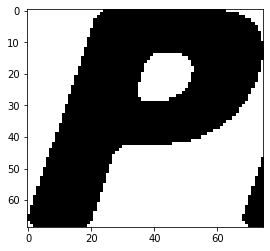

In [11]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img= image.load_img('C:/Users/bivan/Desktop/preprocessing/Images/roi0.png')
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = np.asarray(img_array, dtype = np.float32).reshape(1, 64, 64, 1) / 255 

predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[-1])

print(
    "This image most likely is {} with a {:.2f} percent confidence.".format(categories[list(categories.keys())[np.argmax(score)]], 100*np.max(score))
)

In [ ]:
import cv2
#from google.colab.patches import cv2_imshow
'''from google.colab import files
upload = files.upload()'''
categories  = {'0':'0', 'A':'A', 'B':'B', 'C':"C", 'D':'D', 'E':'E', 'F':'F', 'G':'G', 'H':'H', 'I':'I', 'J':'J', 'K':'K', 'L':'L', 'M':'M', 'N':'N', 'O':'O', 'P':'P', 'Q':'Q', 'R':'R', 'S':'S', 'T':'T', 'U':'U', 'V':'V', 'W':'W', 'X':'X', 'Y':'Y','Z':'Z', 'RA':'रा', 'a_':'a', 'b_':'b', 'c_':'c', 'd_':'d', 'e_':'e', 'f_':'f', 'g_':'g', 'h_':'h', 'i_':'i', 'j_':'j', 'k_':'k', 'l_':'l', 'm_':'m', 'n_':'n', 'o_':'o', 'p_':'p', 'q_':'q', 'r_':'r', 's_':'s', 't_':'t', 'u_':'u', 'v_':'v', 'w_':'w', 'x_':'x', 'y_':'y', 'z_':'z', 'kk':'क'} 
#categories = categories.split(',')
img = cv2.imread(r'C:/Users/bivan/Desktop/preprocessing/Images/roi0.png')
img_copy = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (150,150))

img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (64,64))
img_final =np.reshape(img_final, (1,64,64,-1))


img_pred = categories[list(categories.keys())[np.argmax(loaded_model.predict(img_final))]]
#score = tf.nn.softmax(img_pred[0])
#cv2.putText(img, "Dataflair _ _ _ ", (20,25), cv2.FONT_HERSHEY_TRIPLEX, 0.7, color = (0,0,230))
cv2.putText(img, "Prediction: " + img_pred, (20,410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color = (255,0,30))
cv2.imshow('mat',img)


while (1):
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

print(
    "This image most likely is {} with a {:.2f} percent confidence.".format(categories[list(categories.keys())[np.argmax(score)]], 100*np.max(score))
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpbgirc8kd.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpbgirc8kd.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
